# Brainspace tutorial

## Getting Started

*https://brainspace.readthedocs.io/en/latest/pages/getting_started.html*

### Load packages

In [9]:
# General
import numpy as np
import pandas as pd
import os

# Computing
import scipy.io
import sklearn 

# Visualisation
import matplotlib.pyplot as plt  # may need matplotlib generally?
#import vtk

# Neuroimaging
import nibabel as nib
import nilearn

# Gradients
import brainspace


### Load cortical surfaces and data (connectivity matrix)

Load the conte69 cortical surfaces for the left and right hemispheres

In [2]:
from brainspace.datasets import load_conte69  # widely used adult cortical surface template

surf_lh, surf_rh = load_conte69()

print(surf_lh.n_points)
print(surf_rh.n_points)

32492
32492


Plot the conte69 cortical surfaces

### !!! PROBLEM (doesn't work)!!!

/data/u_serio_software/anaconda3/lib/python3.9/site-packages/brainspace/plotting/utils.py:367: RuntimeWarning: All-NaN slice encountered
  specs['min'][:] = np.nanmin(specs['min'], axis=ax, keepdims=True)
/data/u_serio_software/anaconda3/lib/python3.9/site-packages/brainspace/plotting/utils.py:368: RuntimeWarning: All-NaN slice encountered
  specs['max'][:] = np.nanmax(specs['max'], axis=ax, keepdims=True)
/data/u_serio_software/anaconda3/lib/python3.9/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


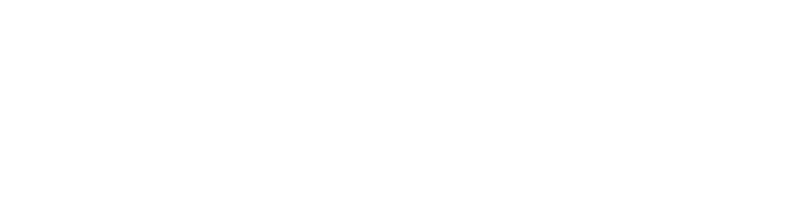

In [3]:
from brainspace.plotting import plot_hemispheres

plot_hemispheres(surf_lh, surf_rh, size=(800, 200), embed_nb = True)

Load the mean connectivity matrix built from a subset of the HCP - the package comes with several example matrices, downsampled using the Schaefer parcellation - here we load one of them

In [4]:
from brainspace.datasets import load_group_fc, load_parcellation

labeling = load_parcellation('schaefer', scale=400, join=True)
m = load_group_fc('schaefer', scale=400)
m.shape

(400, 400)

### Computing Gradients from connectivity matrix

To compute the gradients of our connectivity matrix m we create the GradientMaps object and fit the model to our data

In [5]:
from brainspace.gradient import GradientMaps

# Build gradients using diffusion maps and normalized angle
gm = GradientMaps(n_components=2, approach='dm', kernel='normalized_angle')

# and fit to the data
gm.fit(m)
GradientMaps(alignment=None, approach='dm', kernel='normalized_angle', n_components=2, random_state=None)

# The gradients are in
gm.gradients_.shape

(400, 2)

Now we can visually inspect the gradients. Let’s plot the first gradient

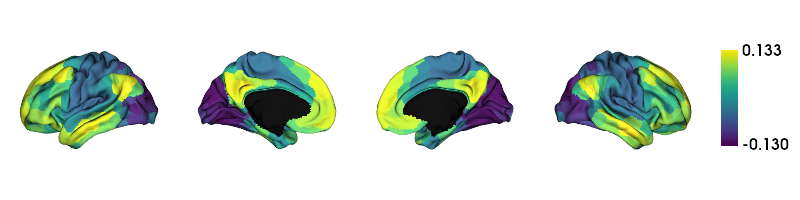

In [6]:
from brainspace.utils.parcellation import map_to_labels

# map to original size
grad = map_to_labels(gm.gradients_[:, 0], labeling, mask=labeling != 0, fill=np.nan)

# Plot first gradient on the cortical surface
plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(800, 200), embed_nb = True, color_bar = True)  # if embed_nb = False (default), plot is interactive in a separate window

As we can see, this gradient corresponds to those observed previously in the literature i.e. running from default mode to sensory areas.

# Tutorial 0: Preparing your data for gradient analysis

In this example, we will introduce how to preprocess raw MRI data and how to prepare it for subsequent gradient analysis in the next tutorials

https://brainspace.readthedocs.io/en/latest/python_doc/auto_examples/plot_tutorial0.html#sphx-glr-python-doc-auto-examples-plot-tutorial0-py

### Preprocessing

Begin with an MRI dataset that is organized in BIDS format. We recommend preprocessing your data using fmriprep, as described below, but any preprocessing pipeline will work.

Following is example code to run fmriprep using docker from the command line:

#### Import the dataset as timeseries

The timeseries should be a numpy array with the dimensions: nodes x timepoints

The following is an example for reading the data:

as a working example, we can fetsch the timeseries from the brainspace datasets:

In [11]:
from brainspace.datasets import fetch_timeseries_preprocessing
timeseries = fetch_timeseries_preprocessing()

### Confound regression

What confounds exactly are we talking about?

To remove confound regressors from the output of the fmriprep pipeline, first extract the confound columns

As a working example, simply read in confounds

In [13]:
from brainspace.datasets import load_confounds_preprocessing
confounds_out = load_confounds_preprocessing()

Do the confound regression

In [14]:
from nilearn import signal
clean_ts = signal.clean(timeseries.T, confounds=confounds_out).T

And extract the cleaned timeseries onto a set of labels

In [15]:
import numpy as np
from nilearn import datasets
from brainspace.utils.parcellation import reduce_by_labels

# Fetch surface atlas
atlas = datasets.fetch_atlas_surf_destrieux()

# Remove non-cortex regions
regions = atlas['labels'].copy()
masked_regions = [b'Medial_wall', b'Unknown']
masked_labels = [regions.index(r) for r in masked_regions]
for r in masked_regions:
    regions.remove(r)

# Build Destrieux parcellation and mask
labeling = np.concatenate([atlas['map_left'], atlas['map_right']])
mask = ~np.isin(labeling, masked_labels)

# Distinct labels for left and right hemispheres
lab_lh = atlas['map_left']
labeling[lab_lh.size:] += lab_lh.max() + 1

# extract mean timeseries for each label
seed_ts = reduce_by_labels(clean_ts[mask], labeling[mask], axis=1, red_op='mean')


Dataset created in /data/hu_serio/nilearn_data/destrieux_surface



 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


### Calculate functional connectivity matrix

In [16]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([seed_ts.T])[0]

Plot the functional connectivity matrix

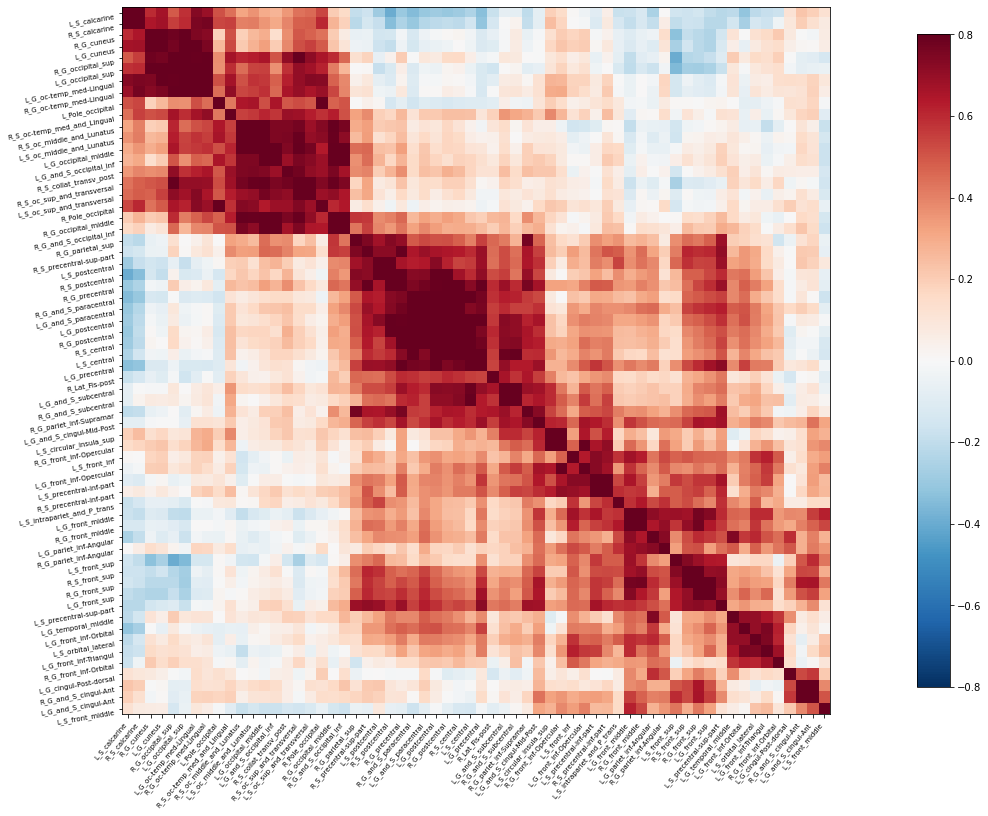

In [17]:
from nilearn import plotting

# Reduce matrix size, only for visualization purposes
mat_mask = np.where(np.std(correlation_matrix, axis=1) > 0.2)[0]
c = correlation_matrix[mat_mask][:, mat_mask]

# Create corresponding region names
regions_list = ['%s_%s' % (h, r.decode()) for h in ['L', 'R'] for r in regions]
masked_regions = [regions_list[i] for i in mat_mask]


corr_plot = plotting.plot_matrix(c, figure=(15, 15), labels=masked_regions,
                                 vmax=0.8, vmin=-0.8, reorder=True)